A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt



# Import any additional modules and start coding below
df = pd.read_csv('rental_info.csv')

# to calculate rental length days, change datatype to datetime format
df['rental_date'] = pd.to_datetime(df['rental_date'])
df['return_date'] = pd.to_datetime(df['return_date'])

# calculate date diff
df['rental_length_days'] = (df['return_date'] - df['rental_date']).dt.days

# adding dummy variables using special features column
df['deleted_scenes'] = np.where(df['special_features'].str.contains("Deleted Scenes"),1,0)
df['behind_the_scenes'] = np.where(df['special_features'].str.contains("Behind the Scenes"),1,0)

# Separate target data from df and drop redundant columns
X = df.drop(['special_features','rental_date','return_date','rental_length_days'], axis=1)
y = df['rental_length_days']

In [60]:
# split data into train and test data
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size= 0.2, random_state= 9)

# Performing feature selection
lasso = Lasso(alpha=0.01, random_state=9)  
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_
 
X_train_selected = X_train.loc[:, lasso_coef > 0]
X_test_selected = X_test.loc[:, lasso_coef > 0]

# LinearRegression
model = LinearRegression()
model.fit(X_train_selected,y_train)
y_pred = model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
print(mse)

# RandomForestRegression
rf = RandomForestRegressor(random_state=9)
rf.fit(X_train_selected, y_train)
rf_pred = rf.predict(X_test_selected)

rf_mse = mean_squared_error(y_test, rf_pred)
print("rf_mse:", rf_mse)



4.846638768993796
rf_mse: 2.3608479570462744


In [61]:
# GridSearchCV
param_grid = {
    'n_estimators' : [50,100,200,300],
    'max_depth': list(range(5,26,2)),
    'max_features': ['log2' , 'sqrt']
}

grid_search = GridSearchCV(
    estimator= RandomForestRegressor(random_state= 42),
    param_grid= param_grid, scoring = 'neg_mean_squared_error', cv =5, n_jobs=-1
)

grid_search.fit(X_train_selected, y_train)
print(grid_search.best_score_)

best_model = grid_search.best_estimator_
test_pred = best_model.predict(X_test_selected)

-2.42489787356734


In [62]:
test_mse = mean_squared_error(y_test, test_pred)
print("Test MSE:", test_mse)

r2 = r2_score(y_test, test_pred)
print("R² Score:", r2)

Test MSE: 2.340946436680045
R² Score: 0.6702692891552982


In [63]:
# which factors influence strongly?

importances = best_model.feature_importances_
features = X_train_selected.columns
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

             Feature  Importance
0             amount    0.581651
2             length    0.331657
1       release_year    0.059212
5  behind_the_scenes    0.011384
3              NC-17    0.008273
4              PG-13    0.007823


Based on the result, 'The amount paid by the customer for renting the DVD' influence to the rental date

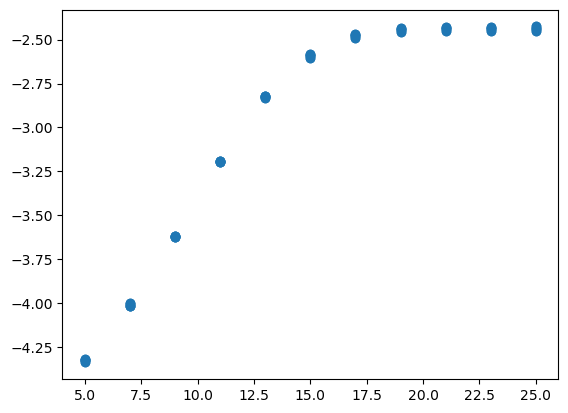

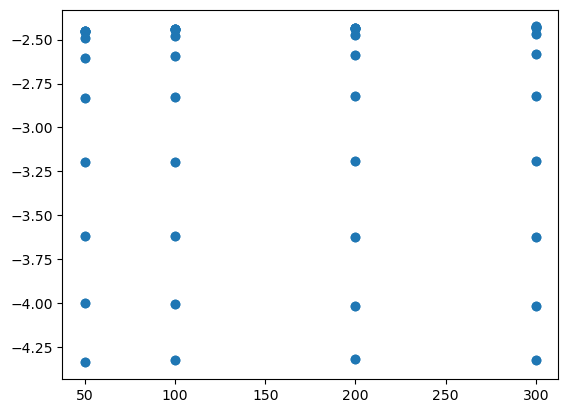

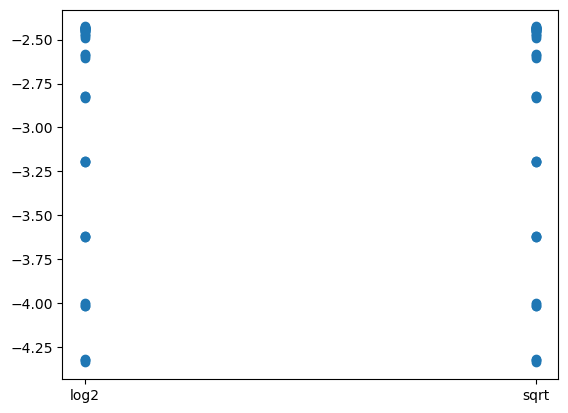

In [64]:
cv_results = pd.DataFrame(grid_search.cv_results_)

plt.scatter(x = 'param_max_depth', y= 'mean_test_score', data=cv_results )
plt.show()

plt.scatter(x = 'param_n_estimators', y= 'mean_test_score', data=cv_results )
plt.show()

plt.scatter(x = 'param_max_features', y= 'mean_test_score', data=cv_results )
plt.show()


In [65]:
print(cv_results.head())


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.222810      0.006971         0.009948        0.000672   
1       0.500163      0.033455         0.039341        0.006615   
2       1.602458      0.128642         0.059415        0.012570   
3       2.252319      0.126029         0.100862        0.031912   
4       0.362372      0.045593         0.015628        0.009046   

   param_max_depth param_max_features  param_n_estimators  \
0                5               log2                  50   
1                5               log2                 100   
2                5               log2                 200   
3                5               log2                 300   
4                5               sqrt                  50   

                                              params  split0_test_score  \
0  {'max_depth': 5, 'max_features': 'log2', 'n_es...          -4.432589   
1  {'max_depth': 5, 'max_features': 'log2', 'n_es...          -4.419602   
2  {'